Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [1]:
NAME = "Jacopo Andreoli"
ID_number = int("2012267") #2011655

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

#  Regression on House Pricing Dataset: Variable Selection & Regularization
We consider a reduced version of a dataset containing house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

For each house we know 18 house features (e.g., number of bedrooms, number of bathrooms, etc.) plus its price, that is what we would like to predict.

In [2]:
#import all packages needed
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(ID_number)

In [3]:
url = "https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/kc_house_data.csv"

data = pd.read_csv(url, sep=',')

# Remove the data samples with missing values (NaN)
data = data.dropna()
# Remove the columns we are not going to use
data = data.drop(columns=['id', 'date'])
# Have a brief description of the dataset
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,3.164000e+03,3164.000000,3164.000000,3164.000000,3.164000e+03,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000
mean,5.354358e+05,3.381163,2.071903,2070.027813,1.525054e+04,1.434893,0.009798,0.244311,3.459229,7.615676,1761.252212,308.775601,1967.489254,94.668774,98077.125158,47.557868,-122.212337,1982.544564,13176.302465
std,3.809004e+05,0.895472,0.768212,920.251879,4.254457e+04,0.507792,0.098513,0.776298,0.682592,1.166324,815.934864,458.977904,28.095275,424.439427,54.172937,0.140789,0.139577,686.256670,25413.180755
min,7.500000e+04,0.000000,0.000000,380.000000,6.490000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,380.000000,0.000000,1900.000000,0.000000,98001.000000,47.177500,-122.514000,620.000000,660.000000
25%,3.150000e+05,3.000000,1.500000,1430.000000,5.453750e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1950.000000,0.000000,98032.000000,47.459575,-122.324250,1480.000000,5429.500000
50%,4.450000e+05,3.000000,2.000000,1910.000000,8.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1545.000000,0.000000,1969.000000,0.000000,98059.000000,47.572500,-122.226000,1830.000000,7873.000000
75%,6.402500e+05,4.000000,2.500000,2500.000000,1.122250e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2150.000000,600.000000,1990.000000,0.000000,98117.000000,47.680250,-122.124000,2360.000000,10408.250000
max,5.350000e+06,8.000000,6.000000,8010.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,6720.000000,2620.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,425581.000000


In [4]:
# Print first 5 datapoints of the dataset
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [5]:
# Let's look at all the possible independent variables and get a feeling on our data. Do not forget we are going 
# to predict the variable 'price' using all the other features 
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
data.shape

(3164, 19)

In [7]:
# Let's split data into train and test using sklearn built-in function: train_test_split (have a look at the 
# documentation)
m_t, m = 300, len(data)
m_test = m - m_t

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=m_test/m, random_state=ID_number)

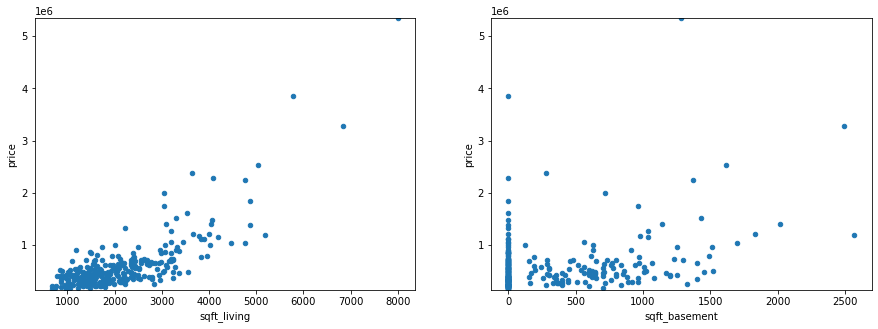

In [8]:
def plot_single_feature_vs_y(feature, train_data, ax=None, y='price'):
    reduced_data = pd.concat([train_data[y], train_data[feature]], axis=1)
    reduced_data.plot.scatter(x=feature, y=y, ylim=(train_data[y].min(), train_data[y].max()), ax=ax)

fig, axes = plt.subplots(1,2, figsize=(15,5))
plot_single_feature_vs_y('sqft_living', train_data, ax=axes[0])
plot_single_feature_vs_y('sqft_basement', train_data, ax=axes[1])

# Note 'sqft_basement' might not be easily used to predict Y (many values are zero while 'price' has different values)

In [9]:
# Let's explore data and feastures distributions using box plots
def box_plot_single_feature_vs_y(feature, train_data):
    plt.figure(figsize=(15,10))
    reduced_data = pd.concat([train_data['price'], train_data[feature]], axis=1)
    sns.boxplot(x=feature, y="price", data=reduced_data)

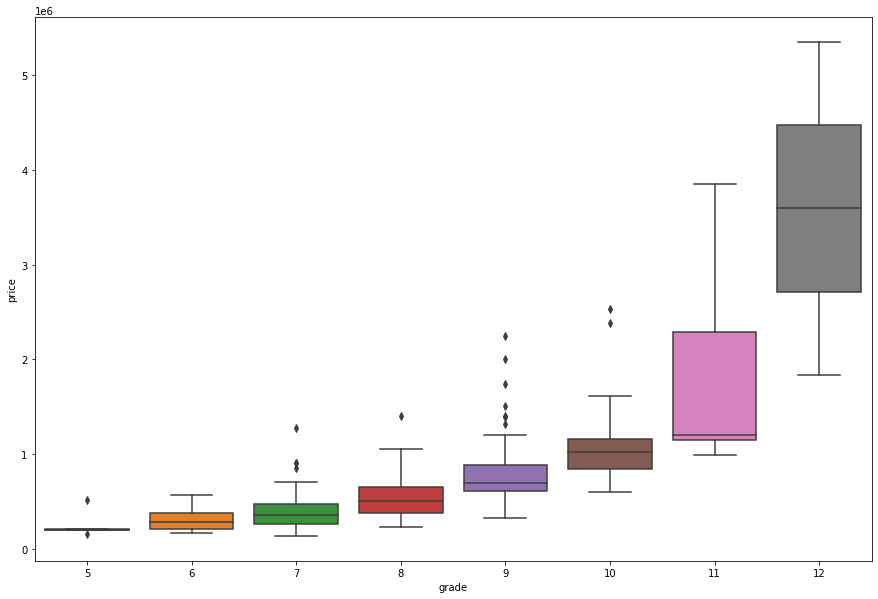

In [10]:
box_plot_single_feature_vs_y('grade', train_data)

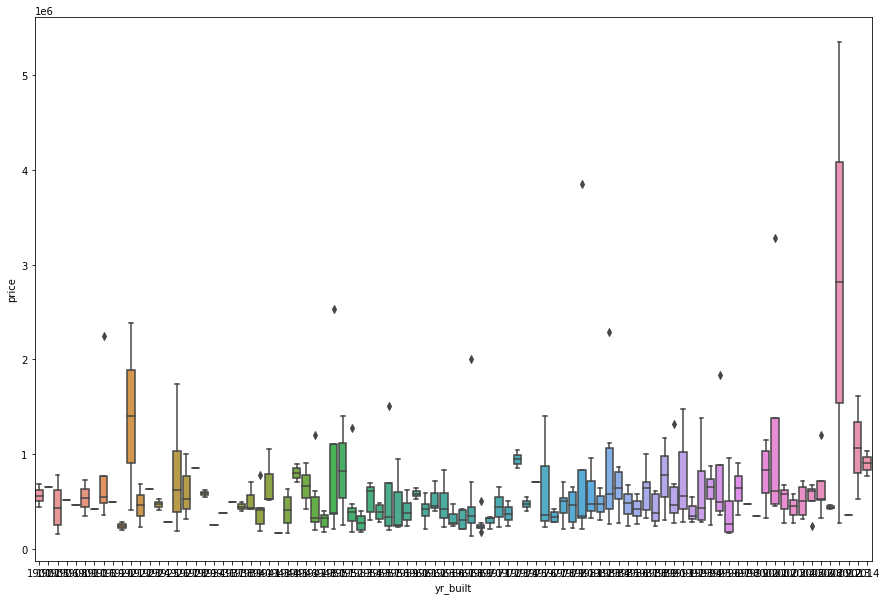

In [11]:
box_plot_single_feature_vs_y('yr_built', train_data)

Note: 'grade' seems to correlate well with the regression variable 'price' (the higher the 'grade' the higher the
 'price'). On the other hand it is not clear whether there is correlation between 'yr_built' and 'price'.
 You can try to inspect other features and how they correlate with 'price'.

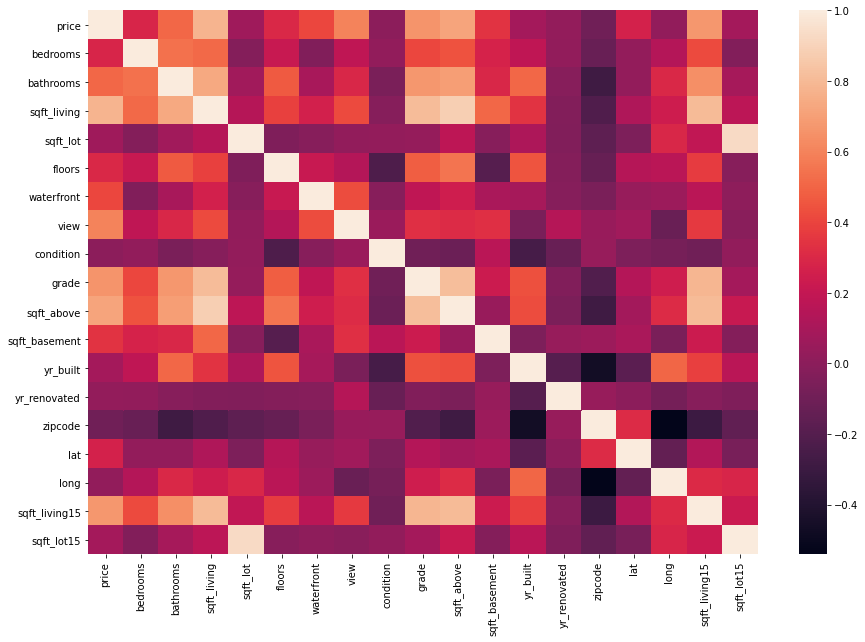

In [12]:
# Let's' try to make the process we followed up to now a little bit more systematic: we will use a pandas 
# built-in function to plot the correlation matrix between all the features and the regression variables.

def plot_correlation_matrix(df_train):
    plt.subplots(figsize=(15, 10))
    corr_matrix = df_train.corr()
    sns.heatmap(corr_matrix, vmax=1, square=False)
    return corr_matrix

corr_matrix = plot_correlation_matrix(train_data)

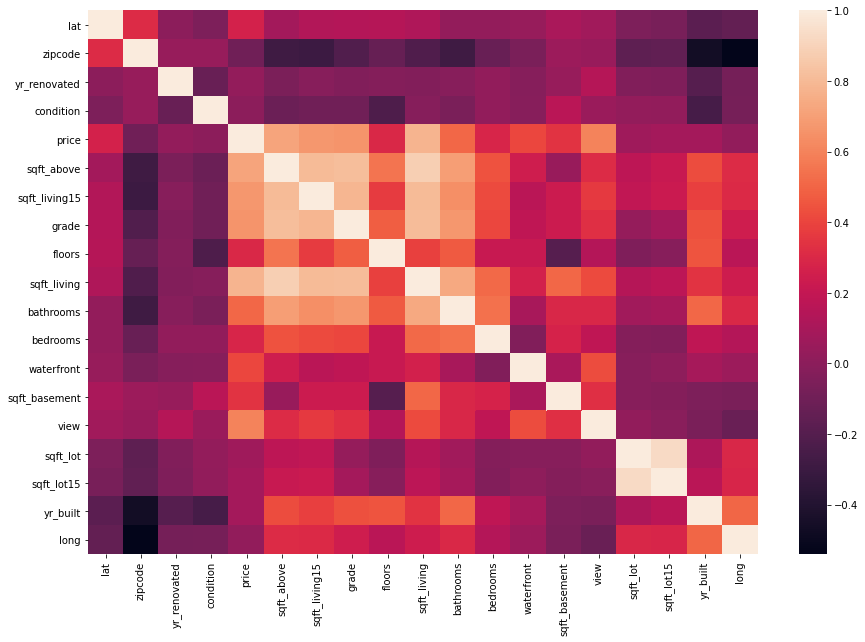

In [13]:
# Previous correlation matrix is not ordered, we need to ordered its entries such that we can cluster the most 
# correlated variables. In this way it will be easier to read the correlation matrix.

import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False) -> pd.DataFrame:
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    :param corr_array: pandas.DataFrame or numpy.ndarray a NxN correlation matrix 
        
    :returns: A NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

plt.subplots(figsize=(15, 10))
corr_matrix = cluster_corr(corr_matrix, inplace=False)
sns.heatmap(corr_matrix, vmax=1, square=False)

Note the 'clusters' along the diagonal (there is high correlation among the following variables):
- 'sqft_above', 'sqft_living15', 'grade', 'bathrooms', 'bedrooms',  'sqft_living'
- 'lat' and 'zipcode'
- 'sqft_lot' and 'sqft_lot15'

Actually, this correlation is so strong that it might indicate a situation of multicollinearity. 
This means these varaibles are in some sense redundant (they give almost the same information) and might not be useful to build our final linear model.

C:\Users\jacop_\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


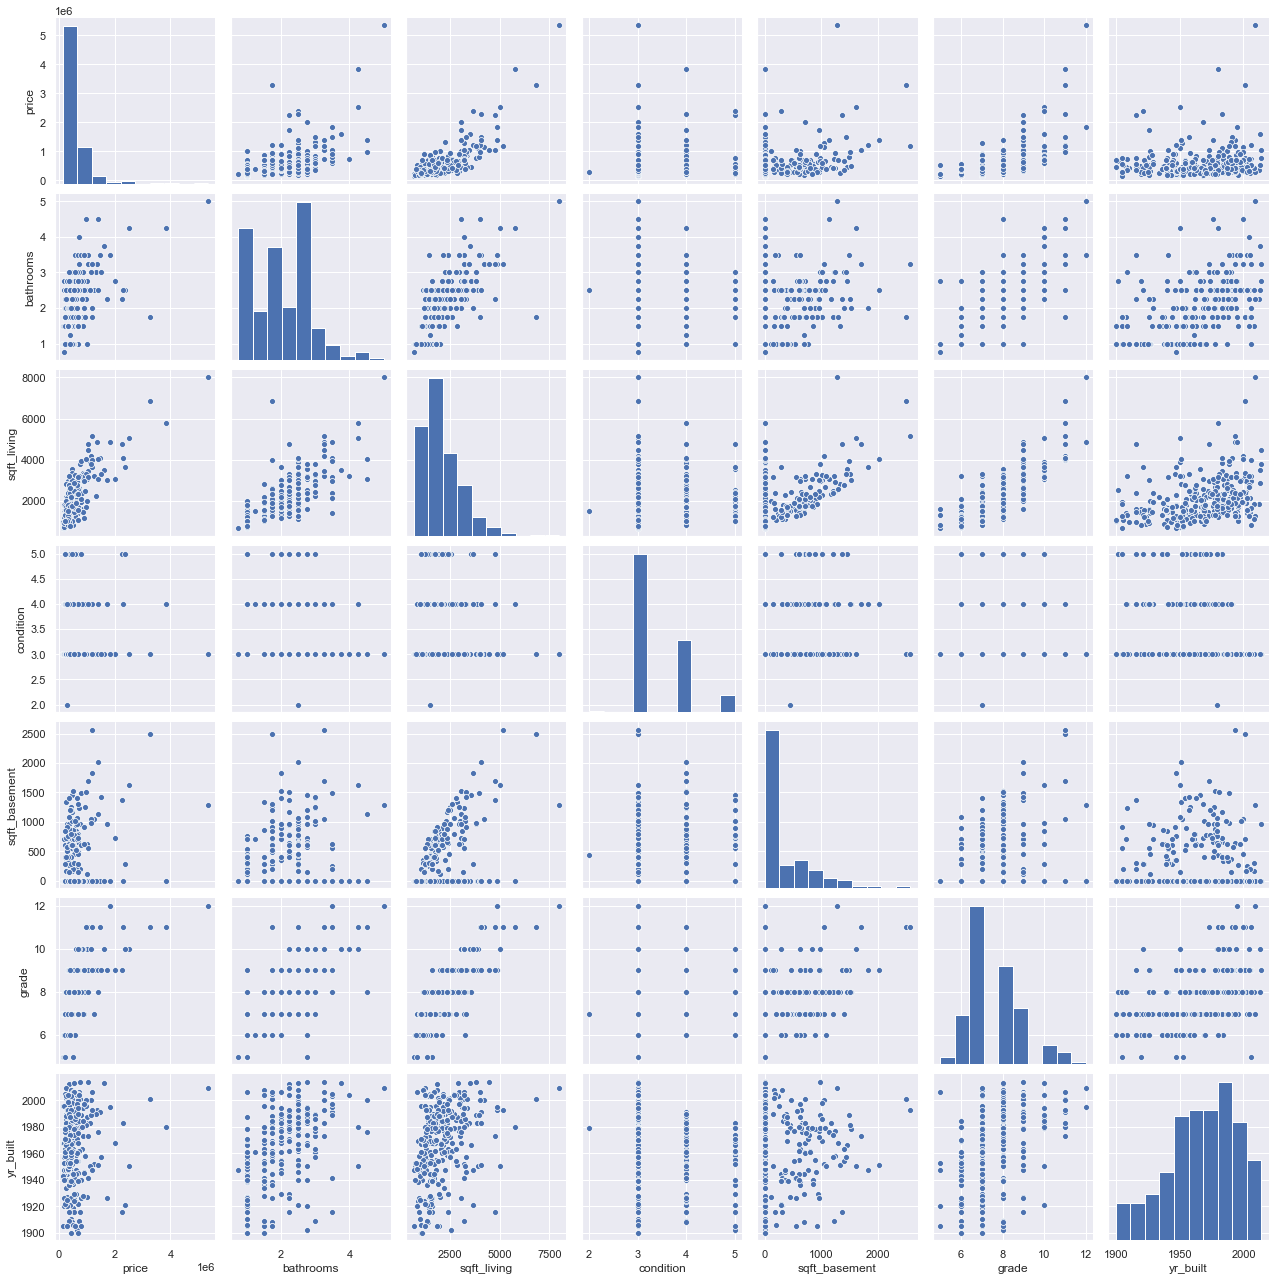

In [14]:
# Let's have a look at some scatter plots 
sns.set()
cols = ['price', 'bathrooms', 'sqft_living', 'condition', 'sqft_basement', 'grade', 'yr_built']
sns.pairplot(train_data[cols], size = 2.5)
plt.show()
# As we see in the correlation matrix 'condition' and 'yr_build' are very poorly correlated

**Note** : We can remove also features that we believe are much correlated with others (as we described earlier they can be thought as redundant). For example we can remove some variables (but not all!!!) in the following list ['sqft_above', 'sqft_living15', 'grade', 'bathrooms', 'bedrooms', 'sqft_living'] (keep only some of them). As a furhter example the very same logic applies to ['sqft_lot', 'sqft_lot15'] features. Don't forget we should keep into account how much each feature is correlated with the regression variable too.

In [15]:
# Let's now standardize the data as we did in the past homeworks
features_names = train_data.columns[1:]
x_train, y_train = train_data[features_names].values.astype('float'), train_data['price'].values.astype('float')
x_test, y_test = test_data[features_names].values.astype('float'), test_data['price'].values.astype('float')

from sklearn import preprocessing
scaler_x = preprocessing.StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)

scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
y_train = scaler_y.transform(y_train.reshape(-1,1)).reshape(-1,)

x_test = scaler_x.transform(x_test)
y_test = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1,)

In [16]:
# TODO 1
# Write a function to compute the Least-Squares estimate using LinearRegression() from Scikit-learn given x_train and 
# y_train. The function must return the COD both for training and test dataset AND must return a vector containing 
# all the model parameters (both w and bias b)
from sklearn import linear_model 
def solve_LS_problem(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array) -> tuple:
    '''
    Funtion used to compute the LS estimate given train data. This function uses Scikit-learn to get both the LS 
    soluion and other required quantities.
    :param x_train: input data used to get the linear model predictions
    :param y_train: output data to be predicted
    :param x_test: test features used to assess model performance
    :param y_test: test output to be predicted to assess model performance
    
    :returns: (COD_train, COD_test, w)
        WHERE
        COD_train : Coefficient of determination for the training dataset (float)
        COD_test : Coefficient of determination for the test dataset (float)
        w : parameters of the linear model (the bias is contained, return it as the first element of w) 
            of shape (#parameters + 1,)
    '''
    
    # YOUR CODE HERE
    x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
    x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))
    linreg= linear_model.LinearRegression()
    linreg=linreg.fit(x_train, y_train)
    COD_train=linreg.score(x_train,  y_train)
    COD_test=linreg.score(x_test,  y_test)
    w=linreg.coef_
    return (COD_train, COD_test, w)

In [17]:
COD_train_LS_full, COD_test_LS_full, w_LS_full = solve_LS_problem(x_train, y_train, x_test, y_test)
print(f"Coefficient of determination on training data: {COD_train_LS_full:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_LS_full:.4f}")

assert w_LS_full.shape == (19,)
assert type(COD_train_LS_full) == np.float64 and COD_train_LS_full <= 1.0
assert type(COD_test_LS_full) == np.float64 and COD_test_LS_full <= 1.0


Coefficient of determination on training data: 0.7935
Coefficient of determination on test data:     0.5692


In [18]:
# TODO 2
# Based on the observations we made earlier looking at the dataset (correlation and scatter plots) which variables 
# would you choose to predict the price? Choose the 4 most important features based on your intuition.
# Here we plot features and their indeces for your ease of use
print({index: feature for index, feature in enumerate(features_names)})

{0: 'bedrooms', 1: 'bathrooms', 2: 'sqft_living', 3: 'sqft_lot', 4: 'floors', 5: 'waterfront', 6: 'view', 7: 'condition', 8: 'grade', 9: 'sqft_above', 10: 'sqft_basement', 11: 'yr_built', 12: 'yr_renovated', 13: 'zipcode', 14: 'lat', 15: 'long', 16: 'sqft_living15', 17: 'sqft_lot15'}


In [19]:
hand_selected_features_indeces = [2, 5, 6, 14] # Replace with a list of 4 indeces and then solve the reduced (in the number of 
                                      # features) LS problem
COD_train_LS_reduced, COD_test_LS_reduced, w_LS_reduced = None, None, None  # Replace with proper values

# YOUR CODE HERE
x_train_reduced=x_train[ :,[2, 5, 6, 14]]
x_test_reduced=x_test[ :,[2, 5, 6, 14]]
COD_train_LS_reduced, COD_test_LS_reduced, w_LS_reduced = solve_LS_problem(x_train_reduced, y_train, x_test_reduced, y_test)
print(f"Coefficient of determination on training data: {COD_train_LS_reduced:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_LS_reduced:.4f}")

Coefficient of determination on training data: 0.7415
Coefficient of determination on test data:     0.5463


In [20]:
assert w_LS_reduced.shape == (5,)


## Best-Subset Selection

What if we try a brute force approach? Are the features you selected the same as the ones you would get looking at all the possible combinations?

In the next cell we are going to split x_train into a ("new") training dataset (x_train_BSS) and validation dataset (x_val_BSS) to perform best-subset selection (remember the validation dataset is used to find the best generalizing model among the ones, with different number of features, you trained using x_train_BSS). 

We are going to choose subsets of features going from 1 to $n_{sub}=4$. In theory we should try all the possible combinations of size 1,2, ..., 18 but the number of models to train and validate would be humongous! For the sake of simplicity we choose all the possible subsets of dimenstion 1 to 4:
1. Compute the LS estimate using all the possible subsets of $k$ features
2. Compute the prediction error on the validation dataset
3. Choose the subset of $k^*$ features givin the lowest validation error.

In [25]:
# TODO 3 
# Let's get the validation dataset from the training dataset (don't forget they must be disjoint, of course we could 
# have splitted them before, during the preprocessing step)
import itertools

m_train_BSS, m_val_BSS = m_t // 2, m_t - m_t // 2

x_train_BSS, y_train_BSS = x_train[:m_train_BSS], y_train[:m_train_BSS]
x_val_BSS, y_val_BSS = x_train[m_train_BSS:], y_train[m_train_BSS:]


nsub = 4
features_idx_dict, validation_err_dict = {}, {}
for k in range(1,nsub + 1):
    features_idx = list(itertools.combinations(range(x_train_BSS.shape[1]), k))
    print(f'Number of models trained for {k} choosen features: {len(features_idx)}')
    validation_error = np.zeros(len(features_idx),)
    for j in range(len(features_idx)):
        # You should use the function you built in previous TODO
        # YOUR CODE HERE
        x_train_new=x_train_BSS
        x_val_new=x_val_BSS
        COD_val_BSS= solve_LS_problem(x_train_new[: ,features_idx[j]], y_train_BSS, x_val_new[: ,features_idx[j]], y_val_BSS)[1]
        validation_error[j] = 1-COD_val_BSS
    
    features_idx_dict.update({k: features_idx})
    validation_err_dict.update({k: validation_error})
    
validation_err_min_per_size = {k+1: np.min(val_errs) for k, val_errs in enumerate(validation_err_dict.values())}
validation_err_argmin_per_size = {k+1: np.argmin(val_errs) for k, val_errs in enumerate(validation_err_dict.values())}

Number of models trained for 1 choosen features: 18
Number of models trained for 2 choosen features: 153
Number of models trained for 3 choosen features: 816
Number of models trained for 4 choosen features: 3060


In [26]:
number_subsets_per_group = [int(scipy.special.comb(18, k)) for k in range(1, nsub + 1)]
for k, n_SubSet in zip(range(1, nsub + 1), number_subsets_per_group): 
    assert len(validation_err_dict[k]) == n_SubSet
    

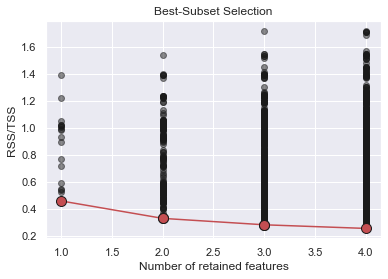

In [27]:
# Plot
plt.figure(2)
for k in range(1,nsub+1):
    plt.scatter(k*np.ones(validation_err_dict[k].shape), validation_err_dict[k], color='k', alpha=0.5)
    if k > 1:
        plt.plot([k-1, k], [validation_err_min_per_size[k-1], validation_err_min_per_size[k]], color='r',marker='o', 
            markeredgecolor='k', markerfacecolor = 'r', markersize = 10)
plt.xlabel('Number of retained features')
plt.ylabel('RSS/TSS')
plt.title('Best-Subset Selection')
plt.show()

In [28]:
# TODO 4
# Pick the number of features for the best subset according to figure above, select the best subset using the results 
# above and learn the model on the entire training data (x_train); eventually compute COD on training (x_train) and 
# on test data (x_test).

# Now pick the number of features according to best subset
opt_num_features = 4
opt_features_idx = features_idx_dict[opt_num_features][validation_err_argmin_per_size[opt_num_features]]

# You should use the function you built in previous TODO
COD_train_BSS, COD_val_BSS, w_hat_BSS = None, None, None # Replace with the proper quantities
# YOUR CODE HERE
x_train_reduced=x_train[ :,opt_features_idx]
x_test_reduced=x_test[ :,opt_features_idx]
COD_train_BSS, COD_val_BSS, w_LS_reduced = solve_LS_problem(x_train_reduced, y_train, x_test_reduced, y_test)

# Let's print the indices of the features from best subset
print(f'Best features indexes: {opt_features_idx}')
print(f'Best features names: {str({features_names[i] for i in opt_features_idx})}')

# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_BSS:.4f}")
print(f"Coefficient of determination on test data:     {COD_val_BSS:.4f}")

Best features indexes: (4, 6, 9, 14)
Best features names: {'floors', 'sqft_above', 'lat', 'view'}
Coefficient of determination on training data: 0.7315
Coefficient of determination on test data:     0.4355


In [29]:
assert len(opt_features_idx) == opt_num_features

### Ridge regression 

We recal that, for linear models with scalar output we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form 
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.

In the case of ridge regression we add a regularization term to the RSS term so that our Empirical error becomes: 
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2 + \lambda \|w\|^2 \propto \|Y - X w\|^2 + \underbrace{\lambda * m_t}_{:=\alpha} \|w\|^2
$$
The ridge least squares solution is given by the expression
$$
\hat w_{ridge} = {\rm arg\;min}_w L_S(w) = (X^\top X + \alpha I)^{-1} X^\top Y
$$
__Note__: what has changed w.r.t. the LS solution? Do we need to worry about invertibility of the matrix we need to invert? 
- Prove that adding to a semi definite positive matrix a positive multiple of identity you get a positive definite matrix.
- Then prove that a positive definite matrix is ALWAYS invertible. 


In [30]:
# TODO 5 
# Write a function which computes the optimal parameters w_hat, solution to the LS regularized problem described 
# earlier.
# We assume w_hat contains the bias term b (as described in class), you will need to create the proper input data 
# adding a fictitious feature containing only ones (it is assumed you add the ones vector before all your features
# so that b_hat in the first position of w_hat). 
# Then write a function "solve_ridge_LS_problem" similar in spirit to "solve_LS_problem" (see function description 
# for details on the input and return values).
def compute_LS_optimal_ridge_ERM_coefficients(x_train : np.ndarray, y_train : np.ndarray, alpha : float) -> np.ndarray:
    '''
    This function estimates the optimal Ridge LS coefficients given the input and output training data x, y. 
    This function assumes the bias term b is condensed with the other coefficients, therefore a column of ones is 
    stacked (place it in front of the feature vector) to the input features and the size of the returned optimal 
    coefficient is: number of features + 1
    
    :param x_train: input features 
    :param y_train: output to be predicted
    :param alpha: regularization parameter
    
    :returns: a column vector containing w_hat, solution to the ridge ERM LS problem    
    '''
    # YOUR CODE HERE
    x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
    inverse=np.linalg.inv(np.matmul(x_train.T, x_train)+alpha*np.identity(x_train.shape[1]))
    w_hat=np.matmul(inverse, np.matmul(x_train.T, y_train))
    return w_hat


def solve_ridge_LS_problem(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array, 
                           alpha : float) -> tuple:
    '''
    Funtion used to compute the ridge LS estimate given train data and alpha hyper-parameter. 
    This function uses Scikit-learn to get both the ridge LS soluion and other required quantities.
    Note you could have implemented this function using your own "compute_LS_optimal_ridge_ERM_coefficients"
    but it is faster and easier for you to compute training loss and test one using Scikit-learn implementation.
    :param x_train: input data used to get the linear model predictions
    :param y_train: output data to be predicted
    :param x_test: test features used to assess model performance
    :param y_test: test output to be predicted to assess model performance
    :param alpha: regularization hyper-parameter
    
    :returns: (COD_train, COD_test, w)
        WHERE
        COD_train : Coefficient of determination for the training dataset
        COD_test : Coefficient of determination for the test dataset
        w : parameters of the linear model (the bias is contained, return it as the first element of w)
    '''
    
    # YOUR CODE HERE
    x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
    x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))
    ridge=linear_model.Ridge(alpha)
    ridge.fit(x_train, y_train)
    COD_train=ridge.score(x_train, y_train)
    COD_test=ridge.score(x_test, y_test)
    w=ridge.coef_
    return (COD_train, COD_test, w)


alpha = 0.1
w_hat_ridge_hand = compute_LS_optimal_ridge_ERM_coefficients(x_train, y_train, alpha = alpha)
print(f"w_hat \n {w_hat_ridge_hand}")

w_hat 
 [-3.03791274e-16 -1.04612045e-01  1.17178028e-02  3.27810643e-01
 -8.63017495e-02 -7.97909076e-02  1.11967832e-01  2.58874681e-01
  1.05998031e-02  5.48835244e-02  3.69571067e-01  1.95904191e-02
 -1.24562776e-01 -2.07569731e-04 -9.18704203e-02  1.62984651e-01
 -1.09377359e-01  5.20103293e-02  6.46633449e-02]


In [31]:
# Compare your ridge regression solution with sklearn one
ridge = linear_model.Ridge(alpha=alpha)
ridge.fit(x_train, y_train)
ridge.coef_.shape, ridge.intercept_.shape
w_hat_ridge_sklearn = np.concatenate((ridge.intercept_.reshape(-1,), ridge.coef_))

COD_train_ridge, COD_test_ridge, w_hat_ridge = solve_ridge_LS_problem(x_train, y_train, x_test, y_test, alpha)

# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_ridge:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_ridge:.4f}")

assert np.isclose(w_hat_ridge_hand, w_hat_ridge_sklearn, atol=1e-8).all()
assert np.isclose(w_hat_ridge_hand, w_hat_ridge, atol=1e-8).all()

Coefficient of determination on training data: 0.7935
Coefficient of determination on test data:     0.5696


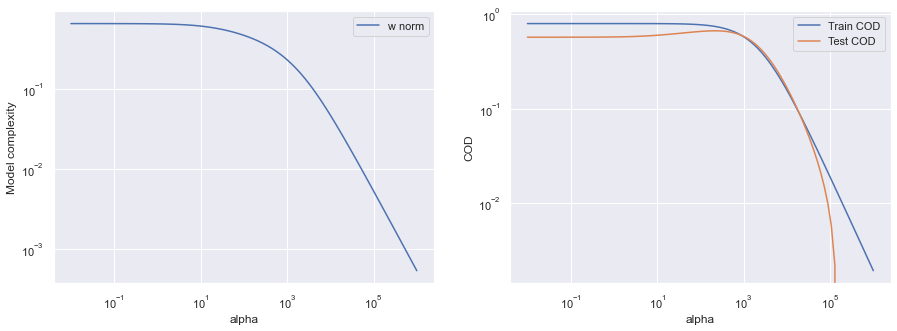

In [32]:
# Let's print model train and test metric as a function of the regularization parameter alpha (which is constraining
# model complexity, the higher the norm of w the higher model complexity)

alphas = np.logspace(-2, 6, 100)
# alphas = np.linspace(1e-2, 1e6, 100)
ridge_results = [solve_ridge_LS_problem(x_train, y_train, x_test, y_test, a) for a in alphas]

train_CODs = list(zip(*ridge_results))[0]
test_CODs = list(zip(*ridge_results))[1]
all_w_hat = list(zip(*ridge_results))[2]

fig, axes = plt.subplots(1,2, figsize=(15, 5))
axes[0].plot(alphas, list(map(np.linalg.norm, all_w_hat)), label='w norm')
axes[0].legend()
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('Model complexity')

axes[1].plot(alphas, train_CODs, label='Train COD')
axes[1].plot(alphas, test_CODs, label='Test COD')
axes[1].legend()
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('COD')

# If you would like to see these plots in log scale in x or y or both just uncomment the following lines
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

In [33]:
# TODO 6 
# How to choose the optimal alpha? This is an hyper-parameter, usually it is estimated using Cross-validation.
# In this TODO we will implement by hand the Cross Validation procedure to estimate hyper-parameter alpha.
# The function we are going to implement is pretty general and can be applied both to Ridge and to Lasso (see next)

from sklearn.model_selection import KFold

def CV_by_hand(num_folds, model_class, other_model_hyper_parameters, loss, hyper_param_range, x_train, y_train):
    kf = KFold(n_splits = num_folds)
    loss_kfold = np.zeros(len(hyper_param_range),)
    for i in range(len(hyper_param_range)):
        for train_index, validation_index in kf.split(x_train):
            # In order to complete the following 2 lines have a look at the documentation of 
            # sklearn.model_selection.KFold (no need to insert new lines, just replace "None" with the correct 
            # quantity)
            x_train_kfold, x_val_kfold = None, None # Assign the correct values
            y_train_kfold, y_val_kfold = None, None # Assign the correct values
            # YOUR CODE HERE
            x_train_kfold, x_val_kfold = x_train[train_index], x_train[validation_index] # Assign the correct values
            y_train_kfold, y_val_kfold = y_train[train_index], y_train[validation_index]
            
            # Initialize the model with the hyper-parameters you are willing to test (in this case we are interested
            # on alpha alone, but we might need to change the number of iterations (or other hyper-parameters, 
            # depending on the model we are using: Ridge, Lasso, etc.) to solve the ERM problem. Therefore we need 
            # to pass such an information using the dictionary "other_model_hyper_parameters")
            model_kfold = model_class(alpha=hyper_param_range[i], **other_model_hyper_parameters)
            
            # Fit the model using training data from the k-fold
            # YOUR CODE HERE
            model_kfold.fit(x_train_kfold, y_train_kfold) 
            
            # Compute the loss using the validation data from the k-fold
            loss_kfold[i] += loss(y_val_kfold, x_val_kfold, model_kfold)

    loss_kfold /= m_t
    
    return loss_kfold


n_alphas, num_folds = 100, 5
alphas = np.logspace(-3,2.5,num = n_alphas)
model_class = linear_model.Ridge
other_model_hyper_parameters = {}
loss = lambda y_val, x_val, model: np.linalg.norm(y_val - model.predict(x_val))**2

# Perform CV with your implemented function
loss_ridge_kfold = CV_by_hand(num_folds, model_class, other_model_hyper_parameters, loss, alphas, x_train, y_train)

assert loss_ridge_kfold.shape == (n_alphas,)

# Choose the regularization parameter that minimizes the validation loss
best_index, ridge_alpha_opt = None, None # Replace with the correct quatities
# YOUR CODE HERE
best_index=np.argmin(loss_ridge_kfold)
ridge_alpha_opt=alphas[best_index]

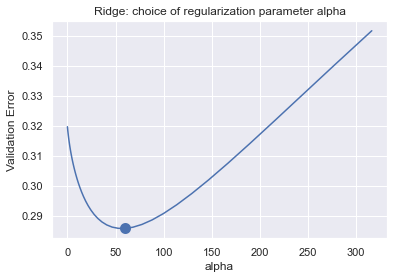

Best value of the regularization parameter: 59.9484
Coefficient of determination on training data: 0.7816
Coefficient of determination on test data:     0.6425


In [34]:

plt.figure()
plt.plot(alphas, loss_ridge_kfold, color='b')
plt.scatter(ridge_alpha_opt, loss_ridge_kfold[best_index], color='b', marker='o', linewidths=5)
plt.xlabel('alpha')
plt.ylabel('Validation Error')
plt.title('Ridge: choice of regularization parameter alpha')
plt.show()

COD_train_ridge_opt, COD_test_ridge_opt, w_hat_ridge_opt = solve_ridge_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                  ridge_alpha_opt)


print(f"Best value of the regularization parameter: {ridge_alpha_opt:.4f}")
# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_ridge_opt:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_ridge_opt:.4f}")

np.random.seed(ID_number) # Do not consider this line, it is only used for evaluation purposes

## Lasso

In the following we will apply a different regularization to our linear model: Lasso (l1 regularization)

Use the routine *lasso_path* from *sklearn.linear_regression* to compute the "lasso path" for different values of the regularization parameter $\lambda$. You should first fix a grid of possible values of lambda (the variable "lasso_lams"). For each entry of the vector "lasso_lams" you should compute the corresponding model (The i-th column of the vector  "lasso_coefs" should contain the coefficients of the linear model computed using lasso_lams[i] as regularization parameter).

Be careful that the grid should be chosen appropriately.

Note that the parameter $\lambda$ is called $\alpha$ in the Lasso model from sklearn


In [35]:
# TODO 7
# As we did for ridge regression and LS, write a function to solve the Lasso LS Problem exploiting sklearn
def solve_lasso_LS_problem(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array, 
                           lam : float) -> tuple:
    '''
    Funtion used to compute the LASSO LS estimate given train data and lambda hyper-parameter. 
    This function uses Scikit-learn to get both the LASSO LS soluion and other required quantities.
    :param x_train: input data used to get the linear model predictions
    :param y_train: output data to be predicted
    :param x_test: test features used to assess model performance
    :param y_test: test output to be predicted to assess model performance
    :param lam: regularization hyper-parameter (what is called alphas in sklearn)
    
    :returns: (COD_train, COD_test, w)
        WHERE
        COD_train : Coefficient of determination for the training dataset
        COD_test : Coefficient of determination for the test dataset
        w : parameters of the linear model (the bias is contained, return it as the first element of w)
    '''
    
    # YOUR CODE HERE
    x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
    x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))
    lassoreg=linear_model.Lasso(alpha=lam)
    lassoreg=lassoreg.fit(x_train, y_train)
    COD_train=lassoreg.score(x_train,  y_train)
    COD_test=lassoreg.score(x_test,  y_test)
    w=lassoreg.coef_
    return (COD_train, COD_test, w)


lam = 0.1
COD_train_lasso, COD_test_lasso, w_hat_lasso = solve_lasso_LS_problem(x_train, y_train, x_test, y_test, lam)

# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_lasso:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_lasso:.4f}")

Coefficient of determination on training data: 0.7274
Coefficient of determination on test data:     0.5660


In [36]:
assert w_hat_lasso.shape == (19,)

In [37]:
# TODO 8
from sklearn.linear_model import lasso_path
# Select a grid of possible regularization parameters (be carefull how this is chosen, you may have to refine 
# the choice after having seen the results)

num_lambdas = 100
lasso_lams = None # Replace with a proper interval (no need to add any line)
# YOUR CODE HERE
lasso_lams = np.logspace(-2,0.5,num = num_lambdas )

# Use the function lasso_path (see documentation) to compute the "lasso path", passing as input the lambda values 
# you have specified in lasso_lams
# YOUR CODE HERE
lasso_coefs=lasso_path(x_train, y_train, n_alphas=num_lambdas, alphas=lasso_lams)[0], lasso_path(x_train, y_train, n_alphas=num_lambdas, alphas=lasso_lams)[1][:,::-1]

In [38]:
assert lasso_coefs.shape == (18, num_lambdas)

Evaluate the sparsity in the estimated coefficients as a function of the regularization parameter $\lambda$: to this purpose, compute the number of non-zero entries in the estimated coefficient vector.

Text(0, 0.5, 'i-th parameter value')

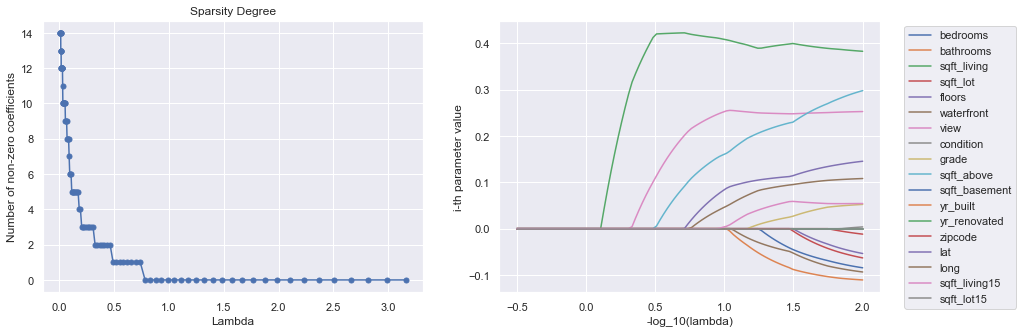

In [39]:
number_non_zero_coeffs = np.zeros(len(lasso_lams),)
# The number of non zero coeffs must be evaluated for each lambda
# YOUR CODE HERE
for i in range(len(lasso_lams)):
    number_non_zero_coeffs[i]=len(np.nonzero(lasso_coefs[:,i])[0])

fig, axes = plt.subplots(1,2, figsize=(15, 5))
axes[0].plot(lasso_lams, number_non_zero_coeffs, marker='o', markersize=5)
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('Number of non-zero coefficients')
axes[0].set_title('Sparsity Degree')

neg_log_alphas_lasso = -np.log10(lasso_lams) # This is used only to make a nice plot (you can directly use: lasso_lams as x value)
for i, coef_l in enumerate(lasso_coefs):
    l1 = axes[1].plot(neg_log_alphas_lasso, coef_l, label=features_names[i])
axes[1].legend(bbox_to_anchor=(1.05, 1))
axes[1].set_xlabel('-log_10(lambda)')
axes[1].set_ylabel('i-th parameter value')

In [40]:
assert len(number_non_zero_coeffs) == num_lambdas

### TODO 9: explain the results in the figures above (max 5 lines)
What does each plot mean? Did you observe what you would have expected from the theory?
Type your answer in the next cell (no code needed)

In [41]:
# YOUR CODE HERE
#
#    In the plot on the left, we can observe what is the sparsity degree of our solution intersted by LASSO, evaluated for
#    every LAMBDA. On the right we can se the so-called "regularizamentation path" with respect to 1/LAMBDA. 
#    Substantially, both of them deal with the characterization of zero component into LASSO solution with respect to 
#    the values of LAMBDA adopted: what we can derive is that the regularizamentation increase with the growth of LAMBDA, while,
#    when we take smaller number, we are moving to the Last Square solution.

In [42]:
# Use Cross-Validation to find the optimal lam. You should use the CV function you implemented earlier.
# Once the omptimal lambda has been found the following cell will automatically print its training and test error
num_folds, num_lambdas = 5, 100
lambdas = np.logspace(-3,0.5,num = num_lambdas) # Replace with a proper interval (no need to add any line)
# YOUR CODE HERE
model_class = linear_model.Lasso
other_model_hyper_parameters = {} # {'max_iter':10000} use this if you want to increase the number of iteration 
                                  # of the optimization not required 
loss = lambda y_val, x_val, model: np.linalg.norm(y_val - model.predict(x_val))**2

# Perform CV with your implemented function
loss_lasso_kfold = CV_by_hand(num_folds, model_class, other_model_hyper_parameters, loss, lambdas, x_train, y_train)

# Do not worry if you get the warning ("Objective did not converge") you cold try to increase the number of iterations
# but the exectution time will increase.

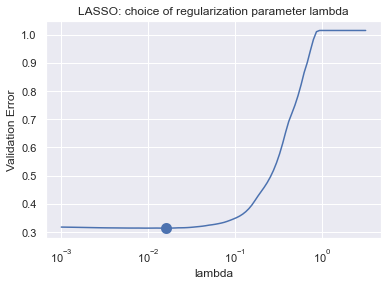

Best value of the regularization parameter: 0.0159
Coefficient of determination on training data: 0.7885
Coefficient of determination on test data:     0.5996
Total number of coefficients: 19
Number of non-zero coefficients: 13


In [43]:
assert loss_lasso_kfold.shape == (num_lambdas,)

# Choose the regularization parameter that minimizes the validation loss
best_index = np.argmin(loss_lasso_kfold)
lasso_lambda_opt = lambdas[best_index]


plt.figure()
plt.plot(lambdas, loss_lasso_kfold, color='b')
plt.scatter(lasso_lambda_opt, loss_lasso_kfold[best_index], color='b', marker='o', linewidths=5)
plt.xlabel('lambda')
plt.ylabel('Validation Error')
plt.title('LASSO: choice of regularization parameter lambda')
plt.xscale('log')
plt.show()

COD_train_lasso_opt, COD_test_lasso_opt, w_hat_lasso_opt = solve_lasso_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                  lasso_lambda_opt)

print(f"Best value of the regularization parameter: {lasso_lambda_opt:.4f}")
# Let's print model performance on train and test datasets (measured using COD)
print(f"Coefficient of determination on training data: {COD_train_lasso_opt:.4f}")
print(f"Coefficient of determination on test data:     {COD_test_lasso_opt:.4f}")
print("Total number of coefficients:", len(w_hat_lasso_opt))
print("Number of non-zero coefficients:", sum(w_hat_lasso_opt != 0))

In [44]:
columns = ['COD_Train', 'COD_Test']
dict_results = {'LS_full': [COD_train_LS_full, COD_test_LS_full],
                'LS_reduced_hand': [COD_train_LS_reduced, COD_test_LS_reduced],
                'LS_reduced_BSS': [COD_train_BSS, COD_val_BSS],
                'ridge_opt': [COD_train_ridge_opt, COD_test_ridge_opt],
                'lasso_opt': [COD_train_lasso_opt, COD_test_lasso_opt] 
               }
results = pd.DataFrame.from_dict(dict_results, orient='index', columns=columns)
results['Gen_gap'] = np.abs(results['COD_Train'] - results['COD_Test'])
results

,COD_Train,COD_Test,Gen_gap
LS_full,0.793546,0.569244,0.224302
LS_reduced_hand,0.741461,0.546323,0.195138
LS_reduced_BSS,0.731487,0.435486,0.296001
ridge_opt,0.781575,0.642540,0.139035
lasso_opt,0.788514,0.599595,0.188919


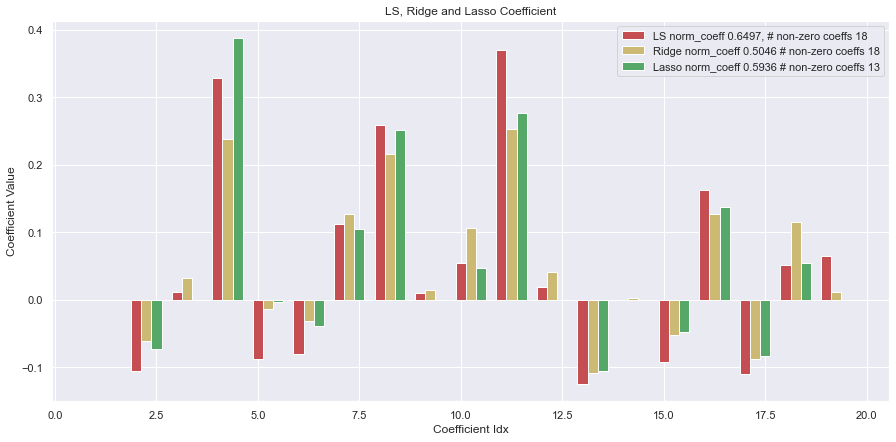

In [45]:
# Let's compare the final coefficients
ind = np.arange(1, len(w_hat_lasso_opt) + 1)  # the x locations for the groups
width = 0.25       # the width of the bars
fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(ind,             w_LS_full,        width, color='r', 
                label=f'LS norm_coeff {np.linalg.norm(w_LS_full):.4}, # non-zero coeffs {sum(w_LS_full != 0)}')
rects2 = ax.bar(ind + width,     w_hat_ridge_opt , width, color='y',
               label=f'Ridge norm_coeff {np.linalg.norm(w_hat_ridge_opt):.4} # non-zero coeffs {sum(w_hat_ridge_opt != 0)}')
rects3 = ax.bar(ind + 2 * width, w_hat_lasso_opt , width, color='g',
               label=f'Lasso norm_coeff {np.linalg.norm(w_hat_lasso_opt):.4} # non-zero coeffs {sum(w_hat_lasso_opt != 0)}')
plt.xlabel('Coefficient Idx')
plt.ylabel('Coefficient Value')
plt.title('LS, Ridge and Lasso Coefficient')
plt.legend()

### TODO 10
Comment and compare the results obtained so far, did you get what you would have expected from the theory?
Type your answer in the next cell (no code needed)

In [46]:
# YOUR CODE HERE
#
#    yes, it is what i expected. In fact, with this plot we can derive the principal affect that the different 
#    regularizamentation can apply on our "classic" Least Square solution. The ridge regression seems like
#    a Least Square problem constrained by a feasible set (iper-sphere) proportionally shrinked by the value of LAMBDA. This
#    also true for the LASSO but in this case we can think the feasible set like a romboid. This form, increase the probability 
#    to obtain a solution to the minimum costrained problem on one of its vertices and for this reason, some component 
#    are put to zero

### How do LS, Ridge and LASSO reject redundant/useless features?
In the next TODOs we are going to create two new hand crafted datasets: 
- first we simply copy the same features a certain number of times (so that we will have redundant features)
- second we simply add random features to the true 18 features we have

Let's see how the models we studied so far behaves in presence of this kind on nuisances.

In [47]:
# Let's first create a function to train and print in one shot all the quantities we are interested on: Training COD,
# Test COD, model parameters.

def solve_Ls_Ridge_Lasso(x_train : np.ndarray, y_train : np.array, x_test : np.ndarray, y_test : np.array):
    # Solve Ordinary LS
    COD_train_LS_full, COD_test_LS_full, w_LS_full = solve_LS_problem(x_train, y_train, x_test, y_test)
    num_folds, n_alphas, num_lambdas = 5, 100, 100
    loss = lambda y_val, x_val, model: np.linalg.norm(y_val - model.predict(x_val))**2
    
    # Solve Ridge 
    alphas = np.logspace(-3,2.5, num = n_alphas)
    loss_ridge_kfold = CV_by_hand(num_folds, linear_model.Ridge, {}, loss, alphas, x_train, y_train)
    best_index_ridge = np.argmin(loss_ridge_kfold)
    ridge_alpha_opt = alphas[best_index_ridge]
    COD_train_ridge_opt, COD_test_ridge_opt, w_hat_ridge_opt = solve_ridge_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                      ridge_alpha_opt)
    
    # Solve LASSO
    lambdas = np.logspace(-10,0, num = num_lambdas)
    loss_lasso_kfold = CV_by_hand(num_folds, linear_model.Lasso, {}, loss, lambdas, x_train, y_train)
    best_index = np.argmin(loss_lasso_kfold)
    lasso_lambda_opt = lambdas[best_index]
    COD_train_lasso_opt, COD_test_lasso_opt, w_hat_lasso_opt = solve_lasso_LS_problem(x_train, y_train, x_test, y_test, 
                                                                                      lasso_lambda_opt)
    
    # The following is simply a copy and paste of what we have done earlier
    columns = ['COD_Train', 'COD_Test']
    dict_results = {
                    'LS_full': [COD_train_LS_full, COD_test_LS_full],
                    'ridge_opt': [COD_train_ridge_opt, COD_test_ridge_opt],
                    'lasso_opt': [COD_train_lasso_opt, COD_test_lasso_opt] 
                   }
    results = pd.DataFrame.from_dict(dict_results, orient='index', columns=columns)
    results['Gen_gap'] = np.abs(results['COD_Train'] - results['COD_Test'])

    # Let's compare the final coefficients
    ind = np.arange(1, len(w_hat_lasso_opt) + 1)  # the x locations for the groups
    width = 0.25       # the width of the bars
    fig, ax = plt.subplots(figsize=(15,7))
    rects1 = ax.bar(ind,             w_LS_full,        width, color='r', 
                    label=f'LS norm_coeff {np.linalg.norm(w_LS_full):.4}, # non-zero coeffs {sum(w_LS_full != 0)}')
    rects2 = ax.bar(ind + width,     w_hat_ridge_opt , width, color='y',
                   label=f'Ridge norm_coeff {np.linalg.norm(w_hat_ridge_opt):.4} # non-zero coeffs {sum(w_hat_ridge_opt != 0)}')
    rects3 = ax.bar(ind + 2 * width, w_hat_lasso_opt , width, color='g',
                   label=f'Lasso norm_coeff {np.linalg.norm(w_hat_lasso_opt):.4} # non-zero coeffs {sum(w_hat_lasso_opt != 0)}')
    plt.xlabel('Coefficient Idx')
    plt.ylabel('Coefficient Value')
    plt.title('LS, Ridge and Lasso Coefficient')
    plt.legend()
    
    return results, fig

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.092963142149131, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.962310711259324, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.701812746866196, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.962310762605023, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.701814246526883, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.325993923002141, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.3259946185977505, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.072923143226991, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.092966865312807, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.325999219680174, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.072927541826754, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.092973225810979, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.092996861842867, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9623384963223263, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.701847375791832, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.962423657010506, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.701944716299618, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.326115251443561, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.962885740061589, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7024733232329545, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.3266134172169615, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.70599349746189, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.329926599097625, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0021349462713118, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9830822700766166, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.887016314876206, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.073904543021115, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0517643653430255, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0793041629321465, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9487318113387246, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

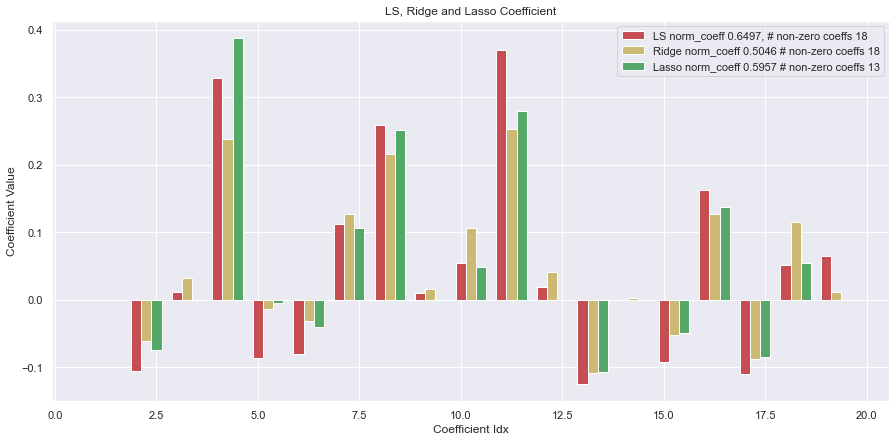

In [48]:
old_results, old_fig = solve_Ls_Ridge_Lasso(x_train, y_train, x_test, y_test)

In [49]:
# We should now see the very same results we obtained earlier
old_results

,COD_Train,COD_Test,Gen_gap
LS_full,0.793546,0.569244,0.224302
ridge_opt,0.781575,0.642540,0.139035
lasso_opt,0.788898,0.599236,0.189662


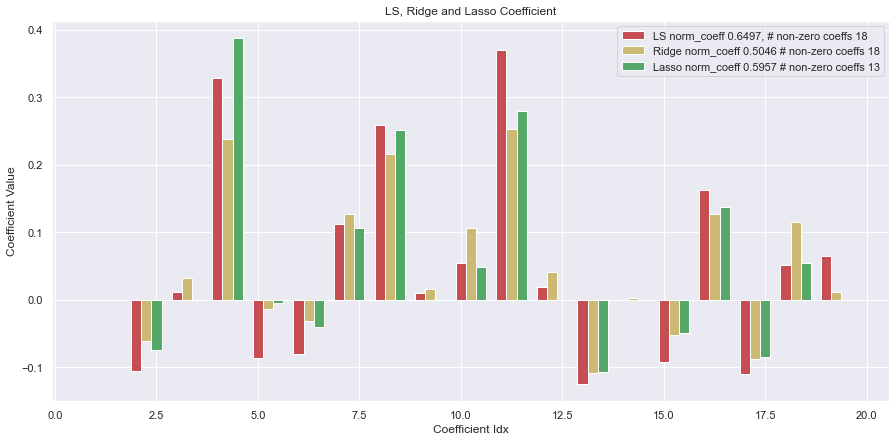

In [50]:
# We should now see the very same results we obtained earlier
old_fig

In [51]:
import random as rm

In [52]:
# YOUR CODE HERE
def replicate_a_random_feature(x_train : np.array, x_test : np.array)->np.array:
    #your code here
    i=rm.randrange(0, x_train.shape[1], 1)
    
    new_column_train=x_train[:,i].reshape(x_train.shape[0],1)
    new_column_test=x_test[:,i].reshape(x_test.shape[0],1)
    
    x_train = np.hstack((x_train, new_column_train))
    x_test = np.hstack((x_test, new_column_test))
    
   #x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
    #x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))
    
    new_x_train=x_train
    new_x_test=x_test
    
    return(new_x_train, new_x_test)

def add_random_feature(x_train : np.array, x_test : np.array) ->np.array:
    
    new_column_train=np.random.normal(0,1,x_train.shape[0])
    new_column_test=np.random.normal(0,1,x_test.shape[0])
    
    x_train = np.hstack((new_column_train.reshape(x_train.shape[0],1), x_train))
    x_test = np.hstack((new_column_test.reshape(x_test.shape[0],1), x_test))
    
 #   x_train= np.hstack((np.ones((x_train.shape[0],1)), x_train))
 #   x_test = np.hstack((np.ones((x_test.shape[0],1)),  x_test))
    
    new_x_train=x_train
    new_x_test=x_test 
    return(new_x_train, new_x_test)



In [69]:
replicated_x_train, replicated_x_test = replicate_a_random_feature(x_train, x_test)
added_x_train, added_x_test = add_random_feature(x_train, x_test)

assert (x_train.shape[0], x_train.shape[1] + 1) ==  replicated_x_train.shape
assert (x_test.shape[0], x_test.shape[1] + 1) ==  replicated_x_test.shape

assert (x_train.shape[0], x_train.shape[1] + 1) ==  added_x_train.shape
assert (x_test.shape[0], x_test.shape[1] + 1) ==  added_x_test.shape

assert np.isclose(added_x_train[:,-1].mean(), 0., atol=1e-1)
assert np.isclose(added_x_train[:,-1].var(), 1., atol=0.5)

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.035175860070712, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.382440651082206, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.340608448022284, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.045923480153657, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.035177333101839, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.382440721082222, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.382442637600258, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.340609467581924, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.621423724273072, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.04593511957199, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.035194566534702, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.382455955500186, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.045972894863656, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.035246988774624, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.382503907172966, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.34096686419204, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.62175230534989, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.04624513137393, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergence

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.34290852310005, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.623535509841101, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.04798016208084, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergenc

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.392572520294523, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.351992862284202, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.631839777852058, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.458132711414763, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.423554619330437, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.942871904252769, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1661099067569651, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06277952624428451, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6950123673449653, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.25309509236067, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.361784355212365, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.488411866658545, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.361784822911712, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.488412863459324, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.344446012100251, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.488417058434095, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.344449716180932, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.24930310555299, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.488439617278996, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.344469931272917, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.249325637339457, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.488591780035257, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.344606276174405, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.24947746804662, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.250211662210727, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.25395846974638, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.362646240906702, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.347719480154714, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.252956686379942, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.256538378354414, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.384185754584394, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3637990632794175, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8717924361370706, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2189142869759575, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9106894245722614, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.480953042799744, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0759482450355478, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1115273464160182, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9800396706724825, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2777915863384273, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.246091562050054, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.394426299917178, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.255849368504968, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.591712913432776, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.277792396004166, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.246097553955625, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.394432440348734, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.255855060011037, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.277819844715639, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.246124670402708, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.394459750822708, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.277936908501257, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.162316732735093, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.394598772634176, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.162876821569615, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.395121945922629, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.256551369580333, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.026568956676401, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.165112670349696, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.397199089678072, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.296306693836289, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.176571558598795, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.519071319734188, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.308915623652002, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.423259359055642, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1440214811660745, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1318511558542923, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9837069567190042, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1499068831066097, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.61389490542383, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.487251298403255, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.788451434823472, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.21431650547793, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.613896180457566, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.48725207393843, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.788455161112928, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.679743906235753, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.214319762498647, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.679760094704378, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.214333067331223, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.613916742259544, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.487333519305736, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.78853053728712, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.67984819169168, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.788958987044477, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.680441100291393, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2148920906958285, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.489371119437216, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.79047893293632, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.682543029718222, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.221408533803304, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.518703134253162, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.49548313063535, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.032206778920319, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.116778319333962, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.149131692274718, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.283652276758289, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0847258780308096, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0123717331765185, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

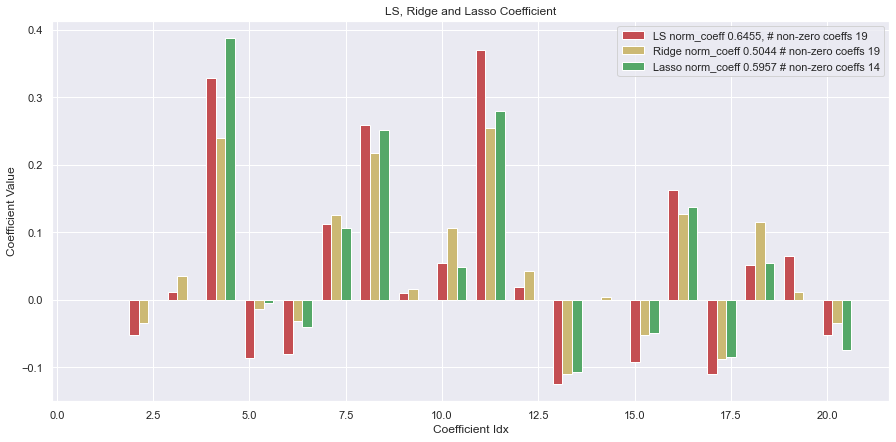

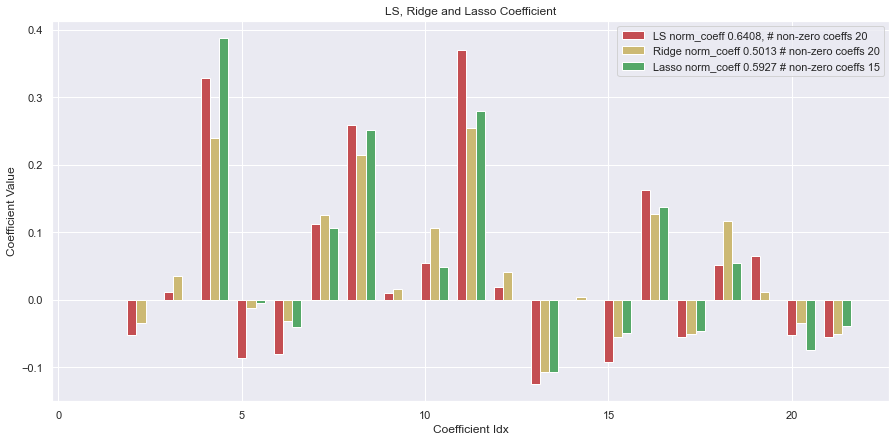

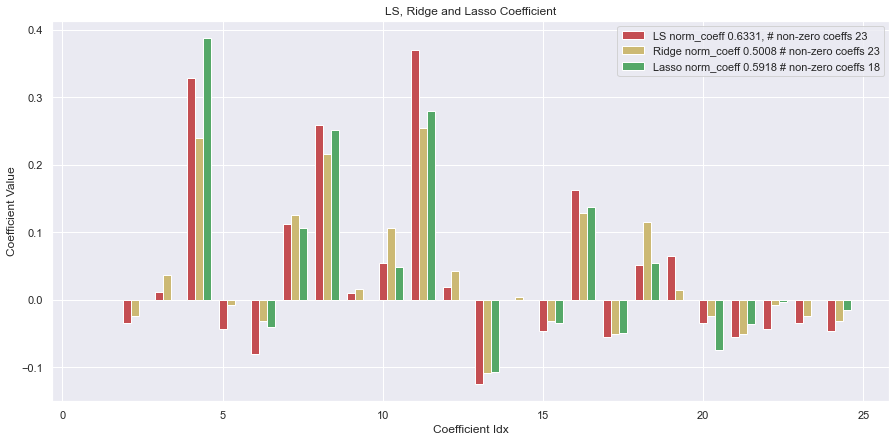

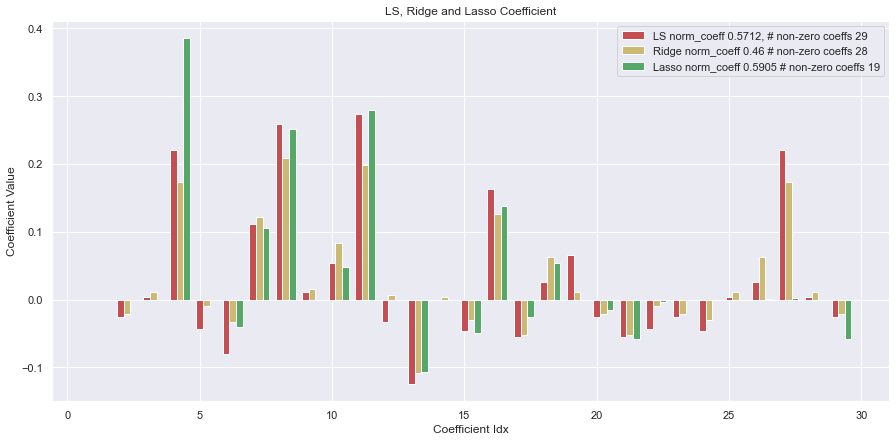

In [80]:
replicated_x_train, replicated_x_test = replicate_a_random_feature(x_train, x_test)
num_duplicated_features, checkpoints = 20, [1,2,5,10,20]
results_at_checkpoints, figs_at_checkpoints = [], []
for i in range(1, num_duplicated_features):
    if i in checkpoints:
        results, fig = solve_Ls_Ridge_Lasso(replicated_x_train, y_train, replicated_x_test, y_test)
        results_at_checkpoints.append(results)
        figs_at_checkpoints.append(fig)
    replicated_x_train, replicated_x_test = replicate_a_random_feature(replicated_x_train, replicated_x_test) 

In [81]:
for checkpoint, results in zip(checkpoints, results_at_checkpoints):
    print(checkpoint, results)

1            COD_Train  COD_Test   Gen_gap
LS_full     0.793546  0.569244  0.224302
ridge_opt   0.781945  0.642767  0.139178
lasso_opt   0.788898  0.599239  0.189659
2            COD_Train  COD_Test   Gen_gap
LS_full     0.793546  0.569244  0.224302
ridge_opt   0.782208  0.641624  0.140584
lasso_opt   0.788898  0.599237  0.189661
5            COD_Train  COD_Test   Gen_gap
LS_full     0.793546  0.569244  0.224302
ridge_opt   0.782646  0.641785  0.140860
lasso_opt   0.788898  0.599238  0.189661
10            COD_Train  COD_Test   Gen_gap
LS_full     0.793546  0.569244  0.224302
ridge_opt   0.784831  0.632752  0.152079
lasso_opt   0.788900  0.599228  0.189672


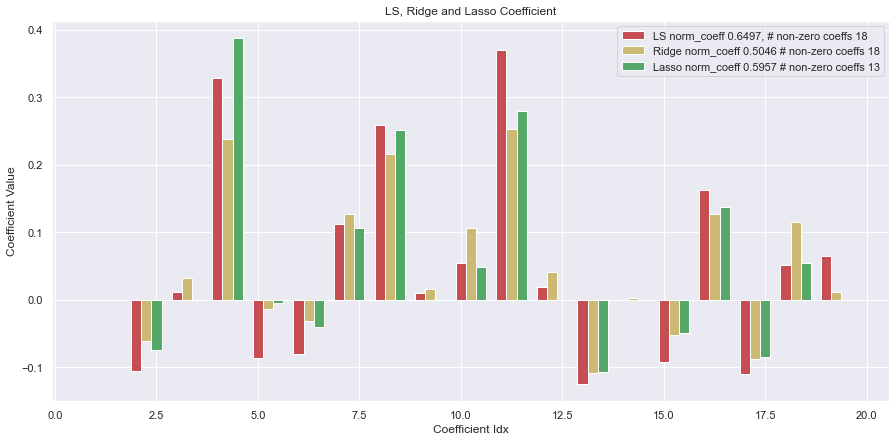

In [72]:
old_fig

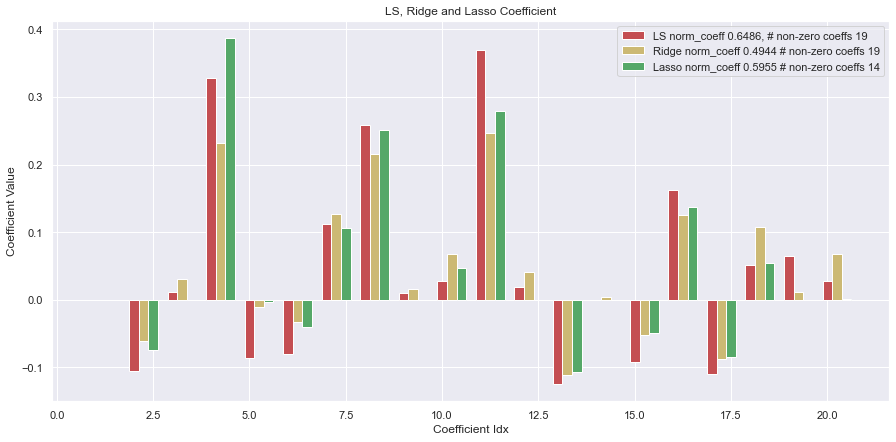

In [73]:
figs_at_checkpoints[0]

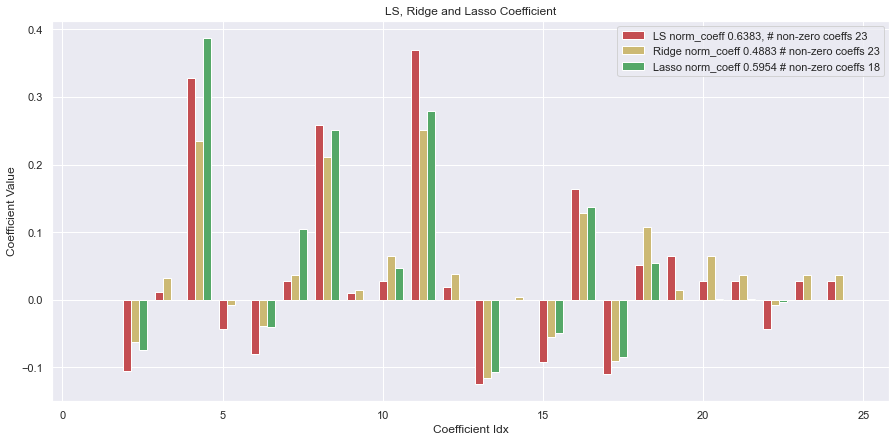

In [74]:
figs_at_checkpoints[2]

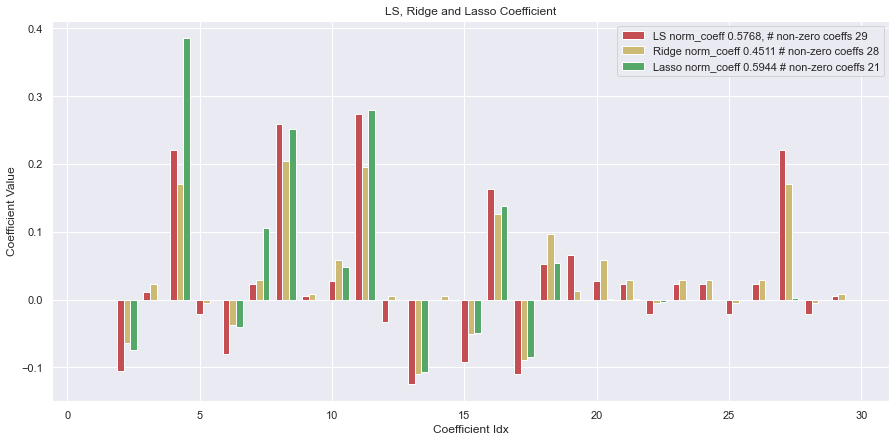

In [75]:
figs_at_checkpoints[-1]

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.043297380825653, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.956181058766548, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.647894402879942, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.956181265705464, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6478964323677445, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.322482605570713, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.043299875846831, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9561820709084294, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6478984056229855, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9561854183482392, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6479022965032435, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.322487354256214, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9562091942260658, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6479298724231946, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.322512887603349, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9563243836167015, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.64806322807576, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.322636806809719, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9570986126590224, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.648960816005307, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.323470641632692, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.327435521482485, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9998749341865363, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9994869976715393, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9814819869565223, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8815290971339493, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0759207384827292, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0514116723039137, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0722678214025194, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9417772228548102, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9359824190264057, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6035563824524495, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.296893909970446, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.144108649711345, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9359826469617065, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.603558978431984, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.603561927306018, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.296896094529064, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.043508777235026, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.603574940129359, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.296908150784553, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.043519944487535, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.144210205816648, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9360717682273663, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.603662823445571, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.297202422080382, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.043791738819387, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.144519211586609, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.29886834166701, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9944394281610371, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8819079709175526, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.944899320603204, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8659440015966595, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0629883747844104, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.882298901582395, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0789723066390735, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.012179545255833, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9681590415215453, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.162225963246918, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11190919934101373, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.111726342485213, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.917556101080846, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5569757746784205, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.289516901379322, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.986370666755533, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.111727112119105, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.986373977131475, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.111731556806237, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9175602973920807, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.289535275823834, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.986388387331139, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.111752097828425, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.557082297091455, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.289613783361325, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.986461844390398, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.290012957894323, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.986835183705654, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.112387225854917, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.292027267217964, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.985259281939129, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.873904632018366, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0617791652148654, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9881364867232563, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.879032749491273, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0031998155191175, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.01852968269516, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4895765404442507, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.894289474225758, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8880530470705086, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3740099942536474, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8554912068050875, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.894291147738247, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8880523194661336, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.894292609106543, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.888053126044394, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.374012133079113, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.894298206094337, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.888057856615461, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.374018035813098, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.374038333046705, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.244940456227077, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.855514396973874, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.374184751845849, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2450743067300465, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9628597443667033, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.888646421128408, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.374710221047469, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.245554624559208, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.247476167819503, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.963751367476533, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.817758527293954, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9666647684801433, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8230606565806156, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8995480131345612, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48188176257688653, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.848195780825229, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0708383318930004, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1399588988854958, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0442630051181823, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0856480886672415, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.352285745325734, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.560582374601111, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7629853673252587, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.94317906985815, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.352286643892093, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.560583043907069, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7629876724336704, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.042450147837744, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.943180873530313, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converg

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.943191425921906, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3522989749161525, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.560600076792408, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.560653695858456, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7630464865665534, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.042519646037796, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.042738914423811, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.943448125803201, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.35254268385582, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Convergen

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.764561794473602, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.044313292420547, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.944904607220192, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Converge

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7707742271425815, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7791720975905179, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.951768308864814, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9402539378709633, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46243587355611027, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7986035160541931, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0644475339529862, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9414509284212045, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0007593512154216, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7186927385449025, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5503105451074344, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1569577628356544, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.432966038823608, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5779298310651866, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7150425619600078, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1569604887986884, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.432968073943515, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.57793160671703, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5503197184716573, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1569668922894056, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4329760509887812, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5779597836506527, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7138839186016845, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.550345542018933, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.157067622051194, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4331020562976597, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5780525380736146, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.433516506734824, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5784266688596587, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7141767892403479, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Con

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5520974407836867, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1587337019325563, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4351850299447353, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conv

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.584283835591438, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7181626139079533, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5999960516426377, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conver

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5775734858690633, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6026526076324004, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7312174020700972, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Co

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2902902618914798, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7828250922497055, tolerance: 0.02827050046191599
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6437639159705917, tolerance: 0.025838892145709
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: Conve

C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6525619820532924, tolerance: 0.022506482565136206
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7299511411268398, tolerance: 0.026640339960831365
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37800748757317315, tolerance: 0.016546340583545833
  model = cd_fast.enet_coordinate_descent(
C:\Users\jacop_\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

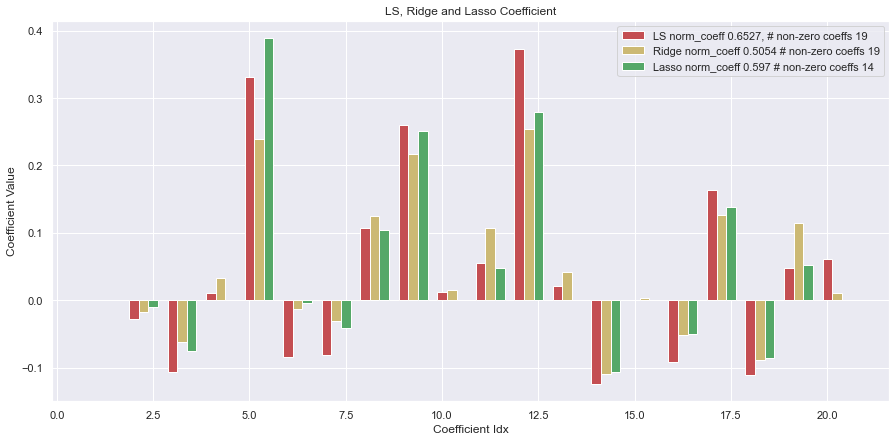

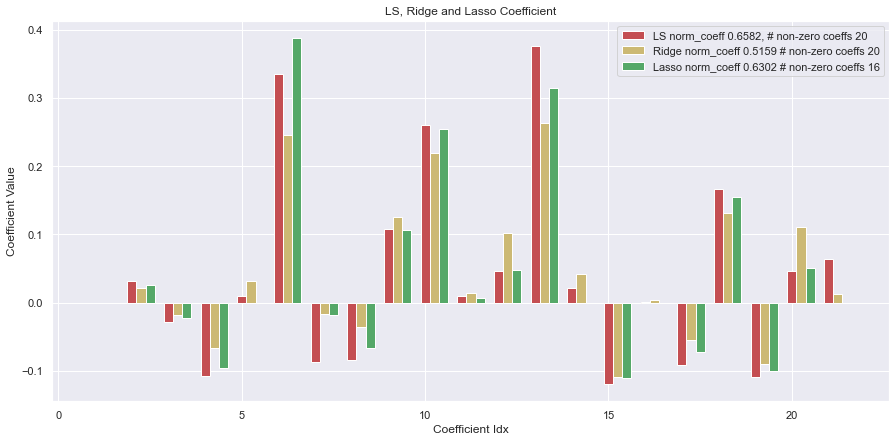

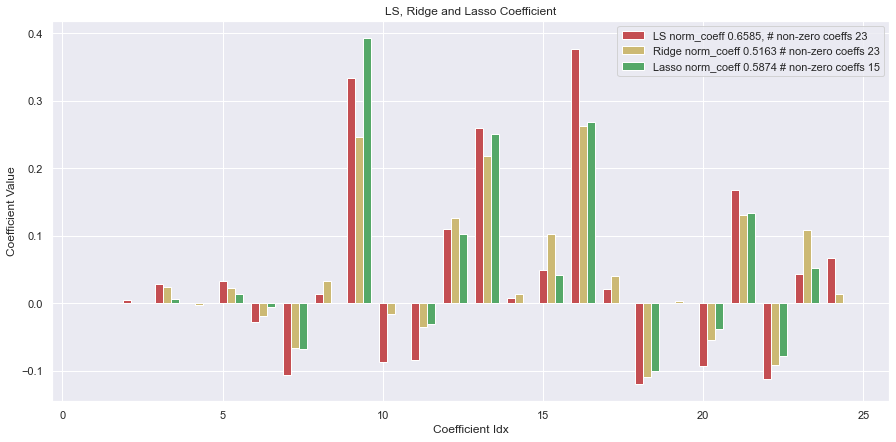

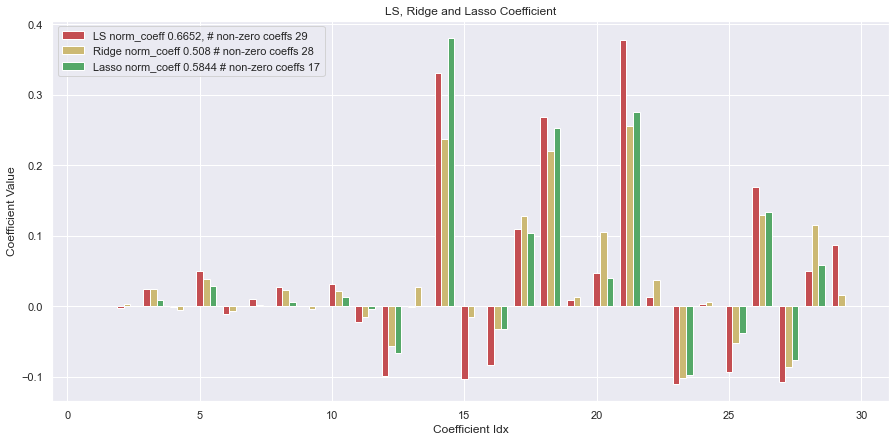

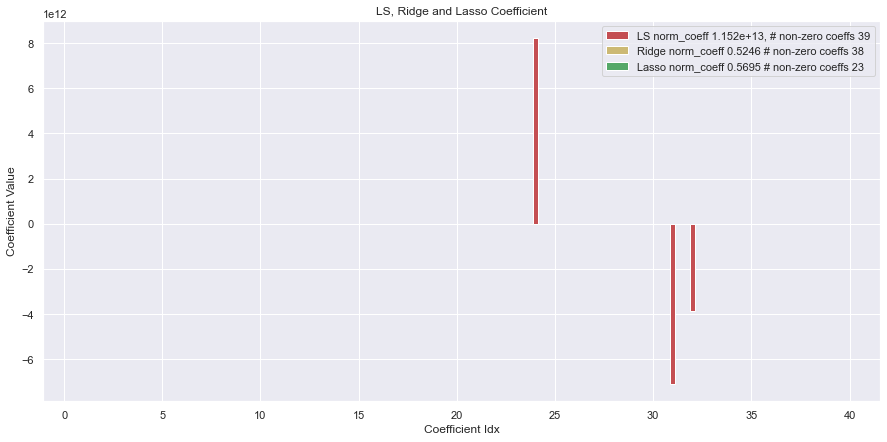

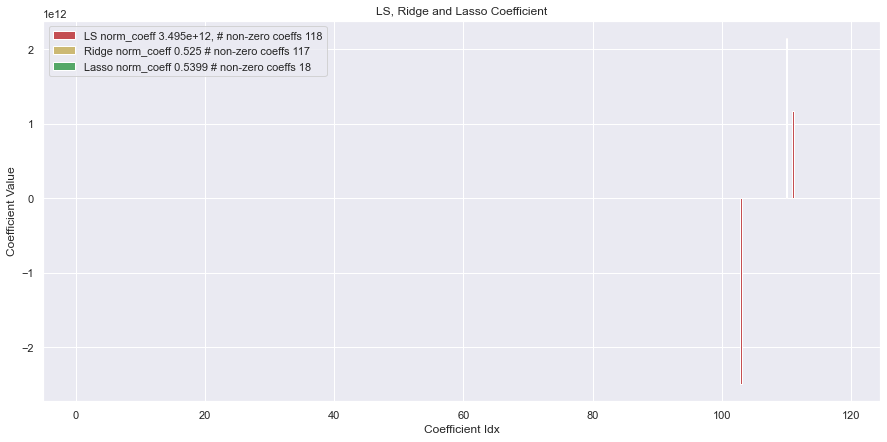

In [76]:
added_x_train, added_x_test = add_random_feature(x_train, x_test)
num_added_features, checkpoints = 100, [1,2,5,10,20,99]
added_results_at_checkpoints, added_figs_at_checkpoints = [], []
for i in range(1, num_added_features):
    if i in checkpoints:
        results, fig = solve_Ls_Ridge_Lasso(added_x_train, y_train, added_x_test, y_test)
        added_results_at_checkpoints.append(results)
        added_figs_at_checkpoints.append(fig)
    added_x_train, added_x_test = add_random_feature(added_x_train, added_x_test)  

In [77]:
for checkpoint, results in zip(checkpoints, added_results_at_checkpoints):
    print(checkpoint, results)

1            COD_Train  COD_Test   Gen_gap
LS_full     0.794268  0.568933  0.225335
ridge_opt   0.782087  0.642889  0.139197
lasso_opt   0.789336  0.599267  0.190069
2            COD_Train  COD_Test   Gen_gap
LS_full     0.795276  0.562649  0.232627
ridge_opt   0.784641  0.637229  0.147412
lasso_opt   0.794006  0.586918  0.207088
5            COD_Train  COD_Test   Gen_gap
LS_full     0.796010  0.560682  0.235328
ridge_opt   0.785363  0.635529  0.149833
lasso_opt   0.787838  0.598933  0.188906
10            COD_Train  COD_Test   Gen_gap
LS_full     0.798939  0.540217  0.258722
ridge_opt   0.786176  0.630302  0.155874
lasso_opt   0.789873  0.593251  0.196622
20            COD_Train  COD_Test   Gen_gap
LS_full     0.809745  0.502822  0.306923
ridge_opt   0.798573  0.610866  0.187706
lasso_opt   0.790604  0.596470  0.194134
99            COD_Train  COD_Test   Gen_gap
LS_full     0.868763  0.175214  0.693548
ridge_opt   0.840944  0.530425  0.310519
lasso_opt   0.779969  0.598364  0.181605


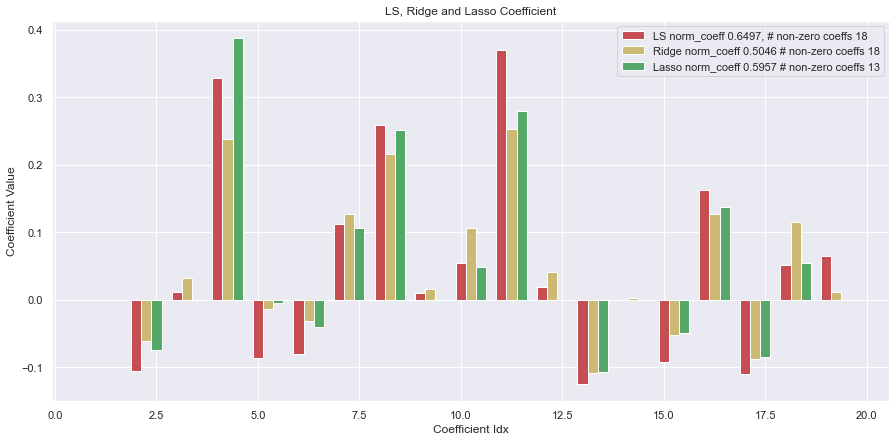

In [62]:
old_fig

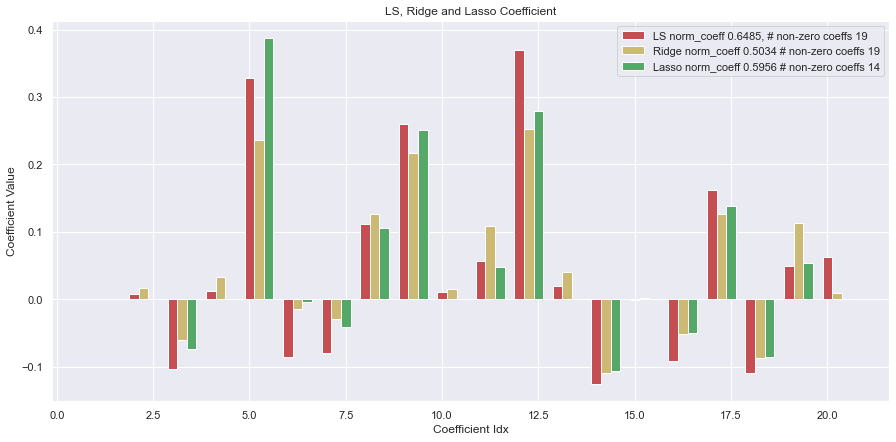

In [63]:
added_figs_at_checkpoints[0]

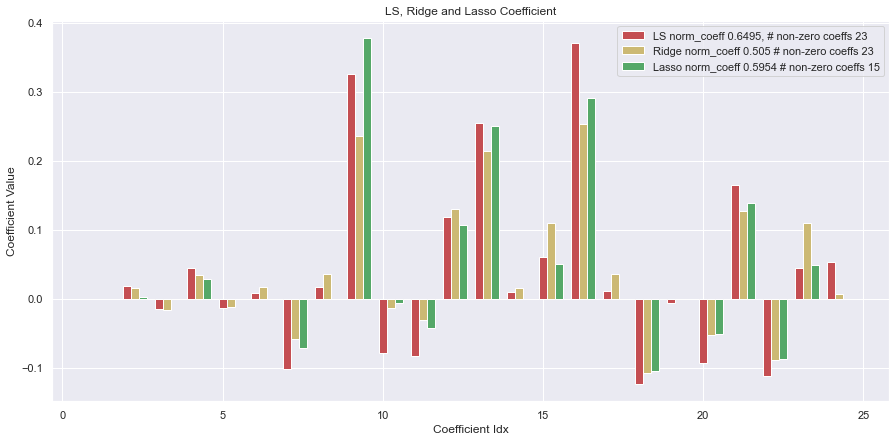

In [64]:
added_figs_at_checkpoints[2]

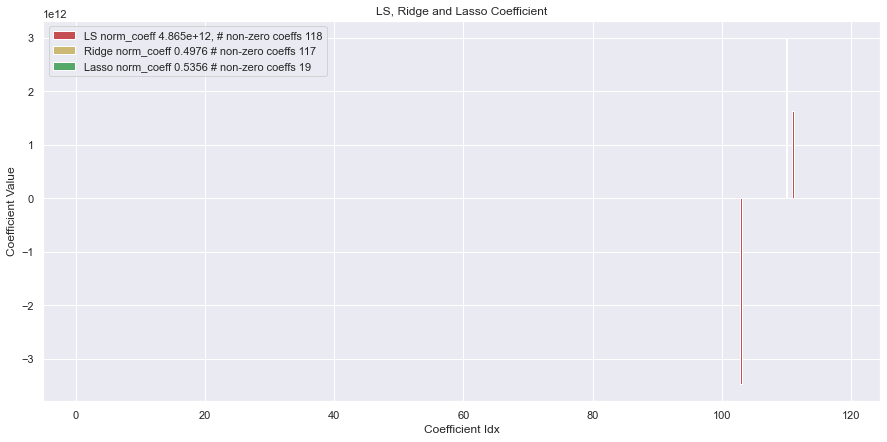

In [65]:
added_figs_at_checkpoints[-1]

### TODO 12 (you do not need more than 5-7 lines)
What do you observe from previous cells. Describe what you found (both on the tables and figures), is this what you expected (describe in particular the generalization gap as a function of the number of redundant and random features).

Answer in the next cell (no need to add any piece of code)

In [66]:
# YOUR CODE HERE
#
#  We can see that the rendundant information doesn't affect so much our model, while inserting random features has importantly
#  increase the gen. gap in the case of LS solution, while in the regularizamentation case, it is less notable. Of course, it is
#  what i expected because the redundant columns doesn't give us new informations about our real model and, for this reason, it 
#  doesn't change our final results for every diffferent solution. Otherwise, the random features, make the LS regression 
#  solution worse but thanks to the regularizamentation, this phenomena is prevent into ridge and Lasso solution. Specifically 
#  we can think at ridge ridge regression like a proportional shrinkage with respect to Lambda of LS solution. Instead, LASSO 
#  put to zero some coefficents when the resulting value of w evaluated become near to zero 

At the beginning of the HW we looked at the distrbutions of the features and their correlation with the regression
variable 'price'. 
We completely overlooked the distribution of 'price' it self. 
The question now is: 
- Can we get some insight on the regression problem looking at the distribution of the regression variable? 
- Can we transform the regression variable to make the regression task easier?

Let's have a look at the distribution of the houses price then! 

In [ ]:
sns.distplot(train_data['price'])
# Note: 
# - This deviates from a normal distribution 
# - Positive skewness (tail above the mean value)
# - Peakedness (single peak)

# Print skewness and kurtosis
print("Skewness: %f" % train_data['price'].skew())
print("Kurtosis: %f" % train_data['price'].kurt())

# Note:
# High skewness might make the regression task harder: few data with very high values, far away from the median
# (but they are not outliers)
# Can we reduce the skewness to make the regression task easier? 

In [ ]:
# How close is this to gaussianity?
sns.distplot(train_data['price'], fit=stats.norm)
# Not that much, BUT it seems to be peaked
# Can we reduce its (right) skewness? Let's try to apply a logarithm to the price (we can use log(x) or log(x+1), the 
# latter allows x to be equals to zero). In the following we will simply use log(x) (it's hard to find an house whose
# price is zero!)
plt.figure()
sns.distplot(np.log(train_data['price']), fit=stats.norm, label='log(x)')
plt.legend()
# Great, we know we can make our regression variable resemble a gaussian distribution if we use a log transform!
# This will greatly simplifies our regression task.

# Homoschedasticity vs Eteroschedasticity
Look at the scater plot of 'price' vs 'sqft_living' (next ) doesn't seems like the variance of the regression variable ('price') is increasing as the 'sqft_living' value increases? In other words, the higher the 'sqft_living' the higher the variance on the price. This is a classical example of Eteroschedasticity (variance of the regressed variable depends on the independent variable).

It is not trivial to model such kind of variance, can we transform data such that they closely resemble homoschedasiticty (variance independent on the independent variable)? 
Put it with other words: can we find a transformation to be applied to the regressed variable such that its scatter plot vs an independent variable does not show a conic shape/diamond?

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
plot_single_feature_vs_y('sqft_living', train_data, ax=axes[0])
# let's try with the log transform which showed to be useful to remove skewness
train_data['price_tranformed'] = np.log(train_data['price'])
plot_single_feature_vs_y('sqft_living', train_data, y='price_tranformed', ax= axes[1])

# Have a look at the following scatter plots, using the log transform we fixed (approximately) also the 
# Eteroschedasticity issue!

In [ ]:
# Not compulsory: try to apply the log transform and see whether the regression becomes easier.